In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from __future__ import print_function
from datetime import datetime

import string
import spacy
import nltk
import re
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold,GridSearchCV

import tensorflow as tf   
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from tensorflow.python.keras import Sequential
from keras.layers import Embedding, LSTM, Dense,Dropout
from scikeras.wrappers import  KerasClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.pipeline import Pipeline
from keras.utils import to_categorical

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix, f1_score,precision_score, recall_score

# Load data

In [3]:
df = pd.read_csv('../data/processed/drug_review_clean.csv', index_col= False)

# Preprocess

# Build a class to do preprocess
The dataframe contains different types of features: numericals ('mean_word_len','word_count', etc), categorical(eg.'rating_category','condidition','drugName'), and datetime ('date'). Also, The target of 'sentiment_label' is categorimcal. The preprocess including the following steps:

1.tokenizer the'review_clean' using keras Tokenizer
2. encode the categorical features and target 'sentiment_label'
3. extract the 'date' to several new features 'year','month','day'.
4.scale the numerical features using MinMaxScaler.
5. train test split

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, max_sequence_length=214):
        self.max_sequence_length = max_sequence_length
        self.tokenizer = None
    """ define a function to convert text to tokenizer """
    def fit(self, X, y=None):
        self.tokenizer = Tokenizer(num_words = 5000, lower = False)
        self.tokenizer.fit_on_texts(X)
        return self
    """ define a function to convert the review text into sequence """

    def transform(self, X):
        sequences = self.tokenizer.texts_to_sequences(X)
        return pad_sequences(sequences, maxlen= 200)


In [5]:
class NumericalScaler(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.scaler = MinMaxScaler()
        self.scaler.fit(X)
        return self

    def transform(self, X):
        return self.scaler.transform(X)

In [6]:
class CategoricalEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y = None):
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(X)
        return self

    def transform(self,X):
        return self.label_encoder.transform(X).reshape(-1,1)

In [7]:
class DateExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self,X):
        X['date'] = pd.to_datetime(X['date'])
        X['year'] = X['date'].dt.year
        X['month'] = X['date'].dt.month
        X['day'] = X['date'].dt.day
        return X[['year','month','day']]               ## should be X[['year','month','day']].values],axis= 1?

In [8]:
X = df[
    [
        "drugName",
        "condition",
        "rating",
        "date",
        "usefulCount",
        "rating_category",
        "review_clean",
        "review_len",
        "mean_sentence_len",
        "word_count",
        "mean_word_len",
        "unique_word_count",
        "sentiment_subjectivity",
        "sentiment_score",
        "genuine_positive",
        "genuine_negative",
        "genuine_neutral",
    ]
]
y = df[["sentiment_label"]]

In [9]:
# Transfrom each feature
df["review_clean"] = df["review_clean"].apply(lambda x: " ".join(x.split()[:200]))
X_text = TextPreprocessor(max_sequence_length=214).fit_transform(df["review_clean"])
numerical_cols = [
    "rating",
    "usefulCount",
    "review_len",
    "mean_sentence_len",
    "word_count",
    "mean_word_len",
    "unique_word_count",
    "sentiment_subjectivity",
    "sentiment_score",
]
X_numerical = NumericalScaler().fit_transform(df[numerical_cols])
X_drugName = CategoricalEncoder().fit_transform(df["drugName"])
X_condition = CategoricalEncoder().fit_transform(df["condition"])
X_date = DateExtractor().fit_transform(df)

In [10]:
#combine the features
X_transformed = np.concatenate([X_text, X_numerical, X_drugName,
                                X_condition, X_date], axis=1)

In [11]:
#encode targe feature
sentiment_label_encode = LabelEncoder()
y_encode = sentiment_label_encode.fit_transform(df['sentiment_label'])
#y = to_categorical(y_encode)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X_transformed, y_encode, test_size=0.25, random_state=123
)

In [13]:
from sklearn.utils.class_weight import compute_class_weight
unique_labels= np.unique(y_train)
class_weights = compute_class_weight(class_weight="balanced", classes=unique_labels, y=y_train)
class_weight_dict = dict(zip(unique_labels, class_weights))
for label, weight in class_weight_dict.items():
    print(f'Class:{label}, weight:{weight:.2f}')

Class:0, weight:1.26
Class:1, weight:3.15
Class:2, weight:0.53


There weight for postive sentiment (class1) is 3.15, for negtive is 0.53(class 2) and for neutral is 1.26(class 0). This imbalance will be addressed during modeling.

# Modeling


The objective of the model is to predict sentiment accurately while mitigating bias. The datased isimbalanced with more positve sentiments. Employiing accuracy as the primary metric may lead to misleading conclusiions. To avoid this.  The F1 score will serve as the principle metric. Meanwhile, metrics such as traning time, preciison, recall and accuracy scale for each model will be recored. The chosen model will ideally strikes a balance between predictive performance, computational efficiency and the ability to capture sentiment in drug review.

Three models will be exlpored in this sentiment analysis task:

1. Long short term memory(LSTM)
This is a type of recurrent neural network RNN designed for sequential data propressing. For sentiment analysis, LSTM excels in capturing dependencies and nuances in text information over extended sequences. Its abaility to retain and forget information  makes it well suited for tasks  where context plays a crucial role, e.g undersing sentiment in long text.

2. Support Vector Classification (SVC)
   It is a classical maching learning algorithm for multclass classifciation.  it operates by identifying the optimal hyperplance that best separates instances of different classes. Through select kernal, it can enhance the adaptability  and enable to deal with non linear relationships.

3. Multinomial Naive Bayes(MNB)
   it is a probalilistic classification algorithm based on Bayes therem and it is widely used in processing text data.  it assumes independence between features. the simlicity and efficiency make it a great baseline model for text based sentiment analysis taks.



## Multinomial Naive Bayes Model (MNB)

In [14]:
mnb_model = MultinomialNB()
mnb_param_grid = {'alpha': [0.01, 0.1, 0.5, 1.0, 10.0, ],
          'fit_prior': [True, False]
         }
mnb_grid = RandomizedSearchCV(mnb_model, param_distributions=mnb_param_grid, n_jobs=-1, cv=5, verbose=1)

print("MNB Start Time", datetime.now().strftime("%H:%M:%S"))
mnb_grid.fit(X_train,y_train)
print("MNB End Time =", datetime.now().strftime("%H:%M:%S"))


MNB Start Time 00:07:26
Fitting 5 folds for each of 10 candidates, totalling 50 fits
MNB End Time = 00:07:35


MNB shows a fast training time.

In [15]:
print('Best accuracy Through Grid Search : {:.4f}'.format(mnb_grid.best_score_))
print('Best Parameters : {}\n'.format(mnb_grid.best_params_))
mnb_y_pred = mnb_grid.best_estimator_.predict(X_test)

Best accuracy Through Grid Search : 0.3666
Best Parameters : {'fit_prior': True, 'alpha': 10.0}



In [16]:
mnb_f1 = f1_score(y_test, mnb_y_pred,average='macro')
mnb_accuracy = accuracy_score(y_test, mnb_y_pred)
mnb_precision = precision_score(y_test, mnb_y_pred,average='macro')
mnb_recall = recall_score(y_test, mnb_y_pred,average='macro')

print("\n MNB model performance: ")
# Print or use the values as needed
print(f'F1: {mnb_f1:.4f}')
print(f'Accuracy: {mnb_accuracy:.4f}')
print(f'Precision: {mnb_precision:.4f}')
print(f'Recall: {mnb_recall:.4f}')
print(classification_report(y_test, mnb_y_pred))


 MNB model performance: 
F1: 0.3512
Accuracy: 0.3688
Precision: 0.3993
Recall: 0.4997
              precision    recall  f1-score   support

           0       0.29      0.27      0.28      8321
           1       0.21      0.91      0.33      3384
           2       0.70      0.32      0.44     20292

    accuracy                           0.37     31997
   macro avg       0.40      0.50      0.35     31997
weighted avg       0.54      0.37      0.39     31997



## LSTM model

In [17]:
def create_lstm_model(dropout_rate=0, epochs=5, batch_size=32):
    lstm_model = tf.keras.models.Sequential()
    lstm_model.add(Embedding(input_dim=5000, output_dim=32, input_length=214))
    lstm_model.add(LSTM(100))
    lstm_model.add(Dropout(0.2))
    lstm_model.add(Dense(3, activation="softmax"))
    lstm_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    lstm_model.summary()
    return lstm_model

In [18]:
X_train_list = X_train.tolist()
X_test_list = X_test.tolist()

In [19]:
text_preprocessor = TextPreprocessor(max_sequence_length=214)
X_text_train = text_preprocessor.fit_transform(X_train_list)
X_text_test = text_preprocessor.transform(X_test_list)

In [20]:
# add callback to get training and validation metrics for each epoch
from tensorflow.keras.callbacks import Callback


class LossAccCallback(Callback):
    def __init__(self):
        self.losses = []
        self.accuracy = []
        self.val_losses = []
        self.val_accuracy = []

    def on_epoch_end(self, epoch, logs=None):
        self.losses.append(logs["loss"])
        self.accuracy.append(logs["accuracy"])
        val_loss = logs.get("val_loss", None)
        val_accuracy = logs.get("val_accuracy", None)
    
        # Check if 'val_loss' is present in logs before accessing it
        if "val_loss" and 'val_accuracy' in logs:
            self.val_losses.append(logs[val_loss])
            self.val_accuracy.append(logs[val_accuracy])
            # print(f'Epoch {epoch + 1}/{logs["epochs"]} - loss: {logs["loss"]:.4f}'
            #     f'- accuracy: {logs["accuracy"]:.4f} - val_loss: {logs["val_loss"]:.4f}'
            #     f'- val_accuracy: {logs["val_accuracy"]:.4f}'
            # )
        # else:
        #     print(f'Epoch {epoch + 1}/{logs["epochs"]} - loss: {logs["loss"]:.4f}'
        #         f'- accuracy: {logs["accuracy"]:.4f}'
        #     )

        # """visualize the results"""

    def plot_metrics(self):
        epochs = np.arange(1, len(self.losses) + 1)
        plt.figure(figsize=(10, 8))

        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.val_losses, label="validation loss")
        plt.title("Training and Validation Loss")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.val_accuracy, label="validation accuracy")
        plt.title("Training and Validation Accuracy")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend()

        plt.tight_layout()
        plt.show()

In [21]:
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=123)
lstm_model = KerasClassifier(
    model=create_lstm_model, dropout_rate=None, epochs=1, batch_size=None, verbose=1, callbacks=[LossAccCallback()]
)

In [22]:
# param_grids = {
#     'dropout_rate': [0.0, 0.2, ],
#     'epochs': [5,10],
#     'batch_size': [32, 64]
# }

In [23]:
param_grids = {
    'dropout_rate': [0.0],
    'epochs': [3],
    'batch_size': [32],
    'class_weight': [class_weight_dict]
}

In [29]:
from sklearn.metrics import make_scorer
kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=123)
scorers = {
            'f1_score': make_scorer(f1_score, average='micro'),
            'precision_score': make_scorer(precision_score, average='micro'),
            'recall_score': make_scorer(recall_score, average='micro'),
            'accuracy_score': make_scorer(accuracy_score)
          }
lstm_grid = RandomizedSearchCV(
    estimator=lstm_model,
    param_distributions=param_grids,
    cv=kfold,
    scoring = scorers,
    verbose=1, error_score='raise',n_jobs=-1, refit='precision_score'
)

In [30]:
from datetime import datetime
print("Start Time =", datetime.now().strftime("%H:%M:%S"))
lstm_grid_result = lstm_grid.fit(
    X_train, y_train
)
print("End Time =", datetime.now().strftime("%H:%M:%S"))

Start Time = 01:04:22
Fitting 2 folds for each of 1 candidates, totalling 2 fits


C:\ProgramData\anaconda3\envs\Capstone_Three_Project\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 214, 32)           160000    
                                                                 
 lstm (LSTM)                 (None, 100)               53200     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 3)                 303       
                                                                 
Total params: 213503 (834.00 KB)
Trainable params: 213503 (834.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/3


2501/3000 [========================>.....] - ETA: 49s - loss: 0.5027 - accuracy: 0.7187

KeyboardInterrupt: 

In [31]:
best_lstm_params = lstm_grid.best_params_

In [32]:
best_lstm_model = lstm_grid.best_estimator_

In [33]:
y_pred = best_lstm_model.predict(X_test)

1000/1000 [==============================] - 45s 44ms/step


In [34]:
# y_pred = best_lstm_model.predict(X_test)

lstm_f1 = f1_score(y_test, y_pred, average="weighted")
lstm_accuracy = accuracy_score(y_test, y_pred)
lstm_precision = precision_score(y_test, y_pred, average="weighted")
lstm_recall = recall_score(y_test, y_pred, average="weighted")

print("\n LSTM model performance: ")
print(f"best hyperparameters:{best_lstm_params}")
# Print or use the values as needed
print(f"Accuracy: {lstm_f1:.4f}")
print(f"Accuracy: {lstm_accuracy:.4f}")
print(f"Precision: {lstm_precision:.4f}")
print(f"Recall: {lstm_recall:.4f}")

print(classification_report(y_test, y_pred))


 LSTM model performance: 
best hyperparameters:{'epochs': 3, 'dropout_rate': 0.0, 'class_weight': {0: 1.261499237764811, 1: 3.1545565085937755, 2: 0.529019173431653}, 'batch_size': 32}
Accuracy: 0.9196
Accuracy: 0.9197
Precision: 0.9195
Recall: 0.9197
              precision    recall  f1-score   support

           0       0.86      0.85      0.86      8321
           1       0.95      0.96      0.95      3384
           2       0.94      0.94      0.94     20292

    accuracy                           0.92     31997
   macro avg       0.92      0.92      0.92     31997
weighted avg       0.92      0.92      0.92     31997



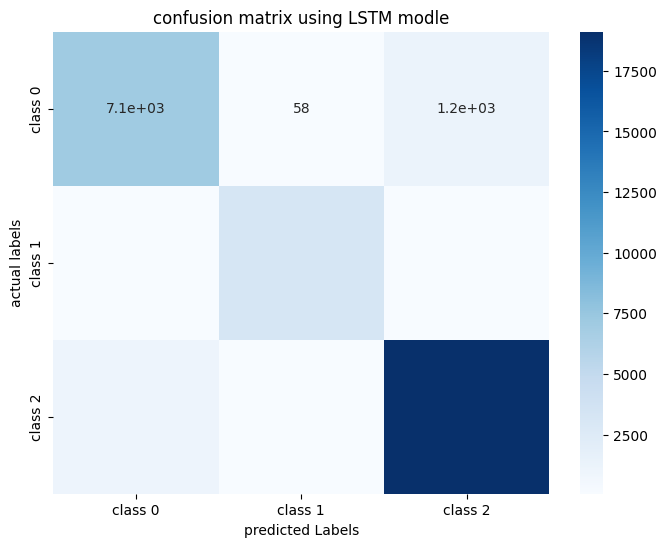

In [35]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    cmap="Blues",
    xticklabels=["class 0", "class 1", "class 2"],
    yticklabels=["class 0", "class 1", "class 2"],
)
plt.xlabel("predicted Labels")
plt.ylabel("actual labels")
plt.title("confusion matrix using LSTM modle")
plt.show()

Fors LSTM, there is no straightforward feature importance as  in traditional machine learning models.    SHapley Additive explanations (SHAP) to explain the lstm model. it presents how much each input feature contirbutes to the output of a model. 

In [36]:
import shap
explainer= shap.DeepExplainer((lstm_grid.layers[0].input, lstm_grid.layers[-1].output), X_train[:100])
# shap_values = explainer.shap_values(X_train)
# # # show the  magnitude and direction of featur impact on the output of the model
# shap.summary_plot(shap_values, X_train)

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


AttributeError: 'RandomizedSearchCV' object has no attribute 'layers'

In [ ]:
sample_index =0
sample_input = X_test[sample_index].reshape(1,-1)
shap_values = explainer.shap_values(sample_input

In [ ]:
# check the attention weights of LSTM
from keras.models import Model

attention_model = Model

## SVC model

In [33]:
svc_model = SVC()

In [34]:
# svc_param_grid = {'C': [0.1,1, 10], 'gamma': [1,0.1,0.01],'kernel': ['rbf', 'poly', 'sigmoid']}
# try simple parameters before finallize tunning
svc_param_grid = {'C': [0.1], 'gamma': [0.1],'kernel': ['rbf'], 'class_weight' : [class_weight_dict]}

In [ ]:
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=123)
svc_grid = RandomizedSearchCV(
    estimator=svc_model,
    param_distributions=svc_param_grid,
    scoring="accuracy",
    cv=2,
    verbose=1,
    error_score="raise",
    n_jobs=-1,
)
svc_grid_results = svc_grid.fit(X_train, y_train)

C:\ProgramData\anaconda3\envs\Capstone_Three_Project\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


In [ ]:
best_svc_params = svc_grid_result.best_params_
best_svc_model = svc_model(**best_lstm_params)
best_svc_model.fit(X_train, y_train)

In [ ]:
svc_pred = best_svc_model.predict(X_test)
svc_accuracy = accuracy_score(y_test, svc_pred)
print("\n svc model performance: ")
print(f'best hyperparameters:{best_svc_params}')
print(f'accuracy:{svc_accuracy}')

# Save The Best Model

In [ ]:
import joblib

In [ ]:
best_lstm_model = lstm_grid_result.best_estimator_
joblib.dump(best_lstm_model, '../Desktop/Capstone_Three_Project/models/best_lstm_model.joblib')

In [ ]:
load_model = joblib.load('best_lstm_model.joblib')

# Summary